In [1]:
import numpy as np
from scipy.stats import mode

def ars(f, num_samples, domain=(-np.inf, np.inf), domain_threshold=1e-15, domain_step=0.1, max_step=int(1e6), 
        init_threshold=1e-5, num_init_points=10, batch_size=100):
    """
    Adaptive Rejection Sampling with batch processing and efficient updates.

    Args:
        f (function): Target probability density function.
        num_samples (int): Number of samples to generate.
        domain (tuple): Range of the distribution.
        domain_threshold (float): Threshold to determine if function value is too small.
        domain_step (float): Step size in adaptive domain search.
        max_step (int): Max step in adaptive domain search.
        init_threshold (float): Threshold to find the initial points.
        num_init_points (int): Number of initial points for constructing envelope (must be >=3).
        batch_size (int): Number of samples to generate per batch before updating the envelope.

    Returns:
        np.array: Array of sampled points.
    """
    # Input checks
    if len(domain) != 2:
        raise ValueError("'domain' must contain exactly two elements.")
    if num_samples <= 0:
        raise ValueError("num_samples must be a positive integer.")
    if batch_size <= 0:
        raise ValueError("batch_size must be a positive integer.")
    
    print("Starting ARS...")
    print("Searching for the domain...")
    if domain == (-np.inf, np.inf):
        mode_value = mode(np.linspace(-5, 5, 100), axis=None).mode[0]  # Estimate the mode heuristically
        domain = adaptive_search_domain(f, start=mode_value, threshold=domain_threshold)
    
    print("Checking if the function is log-concave...")
    if not is_log_concave(f, np.linspace(*domain, 1000)):
        raise ValueError("The input function is not log-concave!")

    h = lambda x: h_log(f, x)
    init_1, init_2 = init_points(f, domain, threshold=init_threshold)
    x_points = np.linspace(init_1, init_2, num_init_points)
    samples = []
    
    # Initialize envelope and squeezing functions
    envelope_pieces, envelope_points = construct_envelope(x_points, h, domain)
    squeezing_pieces, squeezing_points = construct_squeezing(x_points, h, domain)

    while len(samples) < num_samples:
        batch_samples = []
        
        for _ in range(batch_size):
            # Sample from the envelope
            x_star = sample_piecewise_linear(envelope_pieces, envelope_points)
            u = np.random.uniform()
            
            # Check acceptance criteria
            if u <= np.exp(calculate_piecewise_linear(x_star, squeezing_pieces, squeezing_points) - 
                           calculate_piecewise_linear(x_star, envelope_pieces, envelope_points)):
                batch_samples.append(x_star)
            elif u <= np.exp(h(x_star) - calculate_piecewise_linear(x_star, envelope_pieces, envelope_points)):
                batch_samples.append(x_star)
                x_points = np.sort(np.append(x_points, x_star))

        # Update envelope and squeezing functions with the batch
        for x_star in batch_samples:
            envelope_pieces, envelope_points = update_envelope(h, x_points, envelope_pieces, envelope_points, x_star)
            squeezing_pieces, squeezing_points = update_squeezing(h, squeezing_pieces, squeezing_points, x_star)
        
        samples.extend(batch_samples[:num_samples - len(samples)])

    samples = np.array(samples)

    # Output checks
    if not isinstance(samples, np.ndarray):
        raise TypeError("The output 'samples' must be a numpy array.")
    if np.any(np.isnan(samples)) or np.any(np.isinf(samples)):
        raise ValueError("Samples contain NaN or infinite values.")

    print(f"Finished sampling. Total samples collected: {len(samples)}")
    
    return samples

def construct_envelope(hull_points, h, domain):
    """
    Construct the envelope function (upper bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where tangents are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    h_values = h(hull_points)

    slopes = [(h(x+1e-5)-h(x-1e-5))/2e-5 for x in hull_points]
    intercepts = h_values - hull_points * slopes

    z_points = [x_min]
    for i in range(len(hull_points) - 1):
        slope1, intercept1 = slopes[i], intercepts[i]
        slope2, intercept2 = slopes[i + 1], intercepts[i + 1]

        if np.abs(slope1 - slope2) < 1e-10:  # Avoid numerical instability
            raise ValueError("Consecutive slopes are too close; invalid envelope.")
        z_intersect = (intercept2 - intercept1) / (slope1 - slope2)
        z_points.append(z_intersect)

    z_points.append(x_max)
    pieces = [(float(slopes[i]), float(intercepts[i])) for i in range(len(slopes))]
    return pieces, z_points

def construct_squeezing(hull_points, h, domain):
    """
    Construct the squeezing function (lower bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where chords are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    pieces = []
    z_points = [x_min, hull_points[0]]
    
    if x_min == -np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = x_min, hull_points[0]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
    
    for i in range(len(hull_points)-1):
        x1, x2 = hull_points[i], hull_points[i+1]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        z_points.append(x2)
    
    if x_max == np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = hull_points[-1], x_max
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        
    z_points.append(x_max)
    
    return pieces, z_points

def calculate_piecewise_linear(x, pieces, z_points):
    """
    Calculate the value on x for a piecewise linear function.
    
    Args:
        x(float): the point we want to calculate.
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    
    Returns:
        (float): value of the squeezing function at x.
    """
    
    for i in range(len(pieces)):
        if x > z_points[i] and x <= z_points[i + 1]:
            slope, intercept = pieces[i]
            return intercept + slope * x

def update_envelope(h, orig_x_points, orig_pieces, orig_z_points, new_point):
    """
    Add a new point to the update the envelope function.
    
    Args:
        h(function): the log of sampling function f.
        orig_x_points(List): List of the original hull points.
        orig_pieces(list): List of tuples (slope, intercept) representing line segments.
        orig_z_points(list): List of the start and end of each piece.
        new_point(float): new point need to be added to be a new hull point.
        
    Returns:
        new_pieces(list of tuples): List of (slope, intercept) for each segment.
        new_z_points(array_like): Start and end points of each segment.
    """
    domain_min, domain_max = orig_z_points[0], orig_z_points[-1]
    if new_point <= domain_min or new_point >= domain_max:
        raise ValueError(f"New point is out of the domain of the function.")
    
    new_slope = (h(new_point+1e-5) - h(new_point-1e-5))/2e-5
    new_intercept = h(new_point) - new_point * new_slope
    if domain_min < new_point <= orig_x_points[0]:
        if new_point == orig_x_points[0]:
            print("New points already in the hull points.")
            return orig_pieces, orig_z_points
        ## calculate new z point
        slope, intercept = orig_pieces[0]
        z =  -(intercept - new_intercept) / (slope - new_slope)
        orig_z_points.insert(1, z)
        ## insert new piece
        orig_pieces.insert(0, (new_slope, new_intercept))
        return orig_pieces, orig_z_points
    
    for i in range(len(orig_x_points)-1):
        if orig_x_points[i] < new_point <= orig_x_points[i+1]:
            if new_point == orig_x_points[i+1]:
                print("New points already in the hull points.")
                return orig_pieces, orig_z_points

            ## calculate new z_points
            slope1, intercept1 = orig_pieces[i]
            slope2, intercept2 = orig_pieces[i+1]
            z1 = -(intercept1 - new_intercept) / (slope1 - new_slope)
            z2 = -(intercept2 - new_intercept) / (slope2 - new_slope)
            orig_z_points[i+1] = z2
            orig_z_points.insert(i+1, z1)
            ## insert new piece
            orig_pieces.insert(i+1, (new_slope, new_intercept))
            return orig_pieces, orig_z_points
    
    if orig_x_points[-1] < new_point < domain_max:
        ## calculate new z point
        slope, intercept = orig_pieces[0]
        z = -(intercept - new_intercept) / (slope - new_slope)
        orig_z_points.insert(-1, z)
        ## insert new piece
        orig_pieces.append((new_slope, new_intercept))
        return orig_pieces, orig_z_points

def update_squeezing(h, orig_pieces, orig_z_points, new_point):
    """
    Add a new point to the update the squeezing function.
    
    Args:
        h(function): the log of sampling function f.
        orig_pieces(list): List of tuples (slope, intercept) representing line segments.
        orig_z_points(list): List of the start and end of each piece.
        new_point(float): new point need to be added to be a new hull point.
        
    Returns:
        new_pieces(list of tuples): List of (slope, intercept) for each segment.
        new_z_points(array_like): Start and end points of each segment.
    """
    domain_min, domain_max = orig_z_points[0], orig_z_points[-1]
    if new_point <= domain_min or new_point >= domain_max:
        raise ValueError(f"New point is out of the domain of the function.")
    
    for i in range(len(orig_z_points)-1):
        if orig_z_points[i] < new_point <= orig_z_points[i+1]:
            if new_point == orig_z_points[i+1]:
                print("New points already in the hull points.")
                return orig_pieces, orig_z_points
            ## insert new piece
            slope1 = (h(new_point) - h(orig_z_points[i]))/(new_point - orig_z_points[i])
            intercept1 = h(new_point) - slope1 * new_point
            slope2 = (h(new_point) - h(orig_z_points[i+1]))/(new_point - orig_z_points[i+1])
            intercept2 = h(new_point) - slope2 * new_point
            orig_pieces[i] = (slope1, intercept1)
            orig_pieces.insert(i+1, (slope2, intercept2))
            ## insert new z point
            orig_z_points.insert(i+1, new_point)
            return orig_pieces, orig_z_points

def sample_piecewise_linear(pieces, z_points):
    """
    Sample from the exponential of a piecewise linear function.
    
    Args:
        pieces: List of tuples (slope, intercept) representing line segments.
        z_points: List of the start and end of each piece.
    
    Returns:
        A sampled point from the exponential of piecewise linear function.
    """
    # Input checks
    if len(z_points) != len(pieces) + 1:
        raise ValueError(f"Length of `z_points` ({len(z_points)}) should be length of `pieces` ({len(pieces)}) + 1")

    areas, cumulative_areas = [], [0]
    
    for i, (slope, intercept) in enumerate(pieces):
        x_start, x_end = z_points[i], z_points[i + 1]
        if slope == 0:
            area = np.exp(intercept) * (x_end - x_start)
        else:
            log_start = intercept + slope * x_start
            log_end = intercept + slope * x_end
            area = (np.exp(log_end) - np.exp(log_start)) / slope
        areas.append(area)
        cumulative_areas.append(cumulative_areas[-1] + area)

    total_area = cumulative_areas[-1]
    
    # Sample a uniform random value in [0, total_area] to pick a segment
    u = np.random.uniform(0, total_area)
    # Find the segment corresponding to the sampled area
    segment = np.searchsorted(cumulative_areas, u) - 1
    slope, intercept = pieces[segment]
    x_start, x_end = z_points[segment], z_points[segment + 1]

    if slope == 0:
        return np.random.uniform(x_start, x_end)
    else:
        cdf_start = np.exp(np.clip(intercept + slope * x_start, -700, 700)) / slope
        cdf_sample = cdf_start + u - cumulative_areas[segment]
        return (np.log(cdf_sample * slope) - intercept) / slope
    
def adaptive_search_domain(f, start=0, step=0.1, threshold=1e-15, max_steps=int(1e6)):
    """
    Search the domain of the given function.
    
    Args:
    - f(function): Given function we want to search for domain of. 
    - start(float): Starting searching point.
    - step(float): Searching step.
    - threshold(float): Threshold to judge whether the function value is too small.
    - max_steps(int): maximum searching steps.
    
    Returns:
    - domain_start, domain_end(float): The searching domain of the function.
    """
    
    x = start
    domain_points = []
    
    # Searching towards the positive side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        x += step
    
    x = start
    
    # Searching towards the negative side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        else:
            break
        x -= step
    
    if not domain_points:
        raise ValueError("Cannot find the domain in the region, please check your function or change the argument                                 threshold, step or max_steps.")
    return min(domain_points), max(domain_points)

def init_points(f, domain, threshold = 1e-5):
    """
    Search the initial point of the .
    
    Args:
    - f(function): Given function. 
    - domain(tuple): domain of the function.
    - threshold(float): Threshold to judge whether to be the initial point.
    
    Returns:
    - init_1, init_2(tuple): Two initial points.
    """
    
    domain_min, domain_max = domain
    step = (domain_max - domain_min) / 1000
    
    init_1 = domain_min
    while f(init_1) <= threshold:
        init_1 += step
    
    init_2 = domain_max
    while f(init_2) <= threshold:
        init_2 -= step
        
    return init_1, init_2 

def check_overflow_underflow(values, dtype=np.float64):
    """Checks if values are at risk of overflow/underflow, and clip them."""
    min_value = np.finfo(dtype).tiny  # Smallest positive number representable in the dtype
    max_value = np.finfo(dtype).max   # Largest number representable in the dtype
    
    values = np.clip(values, min_value, max_value)

    return values

def h_log(f, x):
    """Manual caching for log of the target function with underflow protection."""
    if isinstance(x, np.ndarray):
        x_key = tuple(x.tolist())  # Convert array to hashable tuple
    else:
        x_key = x

    if x_key not in h_log.cache:
        f_value = f(x)
        f_value = check_overflow_underflow(f_value)
        if isinstance(f_value, np.ndarray):
            f_value = np.maximum(f_value, np.finfo(float).eps)  # Prevent underflow for arrays
        else:
            f_value = max(f_value, np.finfo(float).eps)  # Prevent underflow for scalars
        h_log.cache[x_key] = np.log(f_value)

    return h_log.cache[x_key]

h_log.cache = {}

h_cache = {}

def h_cached(f, x):
    """Cache h values to avoid recomputing for the same x values."""
    if x not in h_cache:
        h_cache[x] = h_log(f, x)
    return h_cache[x]

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def is_log_concave(f, x_range):
    """
    Check if the function f is log-concave over the x_range.
    
    Args:
        f(function): Probability density function (maybe unnormalized)
        x_range(array_like): Range of x values to check
    
    Returns: 
        bool: Whether the function f is concave or not.
    """
    x = np.asarray(x_range)
    f_values = f(x)
    
    if np.any(f_values <= 0):
        raise ValueError("Function values must be positive.")
    
    log_f_values = np.log(f_values)
    
    if log_f_values.ndim == 0:  # Scalar check
        raise ValueError("Function should return an array of values, not a scalar.")
    
    # Compute second derivative
    log_f_second_derivative = np.gradient(np.gradient(log_f_values, x), x)

    # Check second derivative is non-positive (i.e. log-concave condition)
    if np.any(log_f_second_derivative > 1e-10):
        raise ValueError("The function is not log-concave!")    
    is_log_concave = np.all(log_f_second_derivative <= 1e-10)
    
    return is_log_concave

def compare_samples_to_distribution(samples, target_pdf, domain, check_mean=True):
    """
    Compare ARS-generated samples to the target distribution.

    Args:
        samples (np.ndarray): Samples generated by ARS.
        target_pdf (function): The target probability density function.
        domain (tuple): Domain of the distribution as (min, max).
        check_mean (bool): Whether to include mean comparison in the hierarchy.

    Returns:
        None. (Plots and/or prints comparison results.)
    """
    try:
        # 1. If calculable, compare mean
        if check_mean:
            theoretical_mean, success = integrate_mean(target_pdf, domain)
            if success:
                sample_mean = np.mean(samples)
                print(f"Theoretical Mean: {theoretical_mean:.4f}")
                print(f"Sample Mean: {sample_mean:.4f}")
                print(f"Difference in Means: {np.abs(theoretical_mean - sample_mean):.4f}")
                # plt.figure()
                # plt.bar(["Theoretical Mean", "Sample Mean"], [theoretical_mean, sample_mean], color=["red", "blue"])
                # plt.title("Comparison of Means")
                # plt.show()
                # return  # Skip others

    except Exception as e:
        print(f"Mean comparison skipped: {e}")

    try:
        # 2. KS Test
        print("Performing KS Test...")
        empirical_cdf = lambda x: np.mean(samples <= x)
        ks_stat, ks_pvalue = stats.kstest(samples, empirical_cdf)
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")

        if ks_pvalue < 0.05:
            print("Warning: KS Test suggests samples differ significantly from target distribution.")
        else:
            print("KS Test suggests samples align well with target distribution.")

    except Exception as e:
        print(f"KS Test skipped: {e}")

    try:
        # 3. Quantile-Quantile (QQ) Plot
        print("Generating QQ Plot...")
        theoretical_quantiles = np.linspace(domain[0], domain[1], len(samples))
        sample_quantiles = np.quantile(samples, np.linspace(0, 1, len(samples)))

        plt.figure()
        plt.scatter(theoretical_quantiles, sample_quantiles, label="Empirical vs Theoretical")
        plt.plot(theoretical_quantiles, theoretical_quantiles, color="red", linestyle="--", label="Ideal Fit")
        plt.title("QQ Plot")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"QQ Plot skipped: {e}")

    try:
        # 4. KL Divergence
        print("Calculating KL Divergence...")
        sample_pdf_values = target_pdf(samples)
        sample_pdf_values = np.maximum(sample_pdf_values, 1e-10)  # Avoid division by zero
        kl_div = np.mean(np.log(sample_pdf_values) - np.log(stats.gaussian_kde(samples)(samples)))
        print(f"KL Divergence: {kl_div:.4f}")

    except Exception as e:
        print(f"KL Divergence skipped: {e}")

def integrate_mean(pdf, domain, num_points=1000):
    """
    Numerically integrate the mean of a target PDF.

    Args:
        pdf (function): Target probability density function.
        domain (tuple): Domain of the distribution as (min, max).
        num_points (int): Number of points for numerical integration.

    Returns:
        (mean, success) (float, bool): Theoretical mean and success status.
    """
    try:
        x_vals = np.linspace(*domain, num_points)
        pdf_values = pdf(x_vals)
        pdf_values = np.maximum(pdf_values, 1e-10)  # Avoid numerical issues
        mean = np.trapz(x_vals * pdf_values, x_vals) / np.trapz(pdf_values, x_vals)
        return mean, True
    except Exception as e:
        print(f"Error integrating mean: {e}")
        return None, False

Starting ARS...
Searching for the domain...
Checking if the function is log-concave...
New points already in the hull points.
New points already in the hull points.


/var/folders/x_/gkh4zly536b5l5_w7bfzbwt00000gn/T/ipykernel_91715/3355483588.py:146: RuntimeWarning: invalid value encountered in scalar divide
  slope = (h(x2)-h(x1))/ (x2 - x1)
/var/folders/x_/gkh4zly536b5l5_w7bfzbwt00000gn/T/ipykernel_91715/3355483588.py:161: RuntimeWarning: invalid value encountered in scalar divide
  slope = (h(x2)-h(x1))/ (x2 - x1)


Finished sampling. Total samples collected: 5000


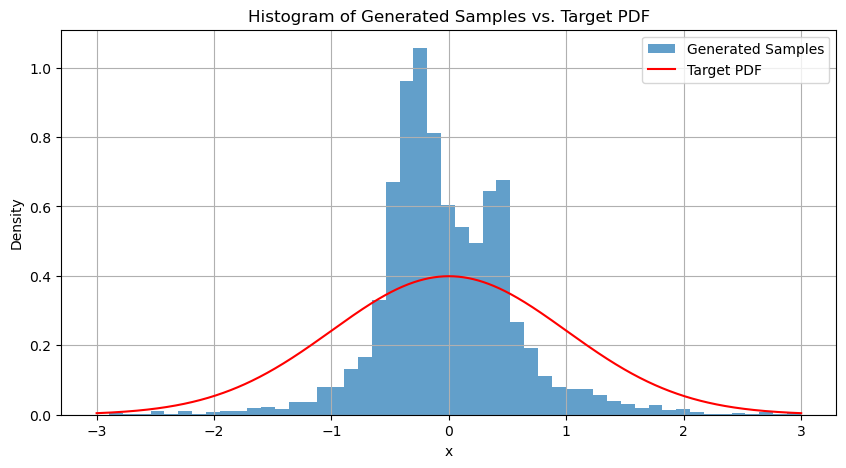

KS Statistic: 0.1830, p-value: 0.0000


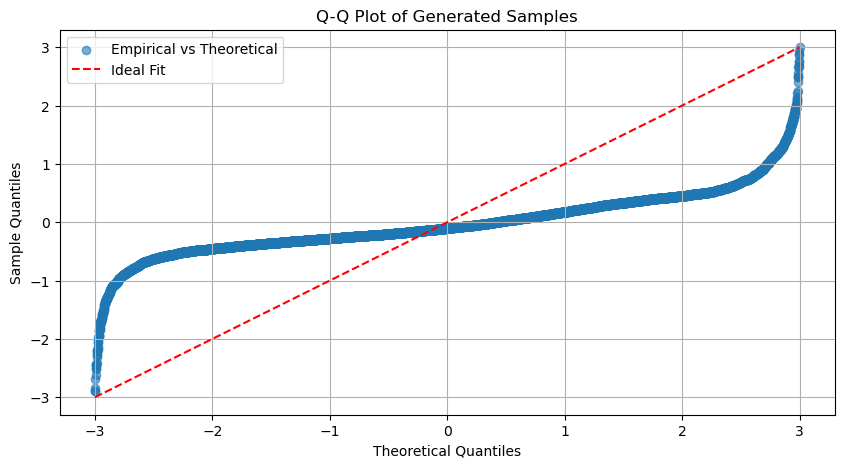

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Perform the KS Test
from scipy.stats import kstest

# Define the target probability density function
def target_pdf(x):
    """
    Truncated normal distribution PDF.
    Mean = 0, Standard Deviation = 1, truncated to [-3, 3].
    """
    if -3 <= x <= 3:
        return norm.pdf(x, loc=0, scale=1)
    else:
        return 0

# Vectorize the target PDF for use with numpy arrays
target_pdf_vec = np.vectorize(target_pdf)

# Number of samples to generate
num_samples = 5000

# Run the ARS sampler
samples = ars(target_pdf_vec, num_samples=num_samples, domain=(-3, 3), num_init_points=10, batch_size=100)

# Plot the histogram of generated samples
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=50, density=True, alpha=0.7, label="Generated Samples")
x = np.linspace(-3, 3, 1000)
plt.plot(x, target_pdf_vec(x), 'r-', label="Target PDF")
plt.title("Histogram of Generated Samples vs. Target PDF")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# Define the CDF of the target distribution
def target_cdf(x):
    if x < -3:
        return 0
    elif x > 3:
        return 1
    else:
        return (norm.cdf(x, loc=0, scale=1) - norm.cdf(-3, loc=0, scale=1)) / \
               (norm.cdf(3, loc=0, scale=1) - norm.cdf(-3, loc=0, scale=1))

# Vectorize the target CDF
target_cdf_vec = np.vectorize(target_cdf)

# Perform KS Test
ks_stat, ks_p_value = kstest(samples, target_cdf_vec)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")

# Generate a Q-Q Plot
sample_quantiles = np.quantile(samples, np.linspace(0, 1, len(samples)))
theoretical_quantiles = np.linspace(-3, 3, len(samples))

plt.figure(figsize=(10, 5))
plt.scatter(theoretical_quantiles, sample_quantiles, alpha=0.6, label="Empirical vs Theoretical")
plt.plot(theoretical_quantiles, theoretical_quantiles, color="red", linestyle="--", label="Ideal Fit")
plt.title("Q-Q Plot of Generated Samples")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.legend()
plt.grid()
plt.show()